In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [10]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [11]:
import pickle
with open('train.pickle', 'rb') as f:
    X, y = pickle.load(f)

In [12]:
from sklearn.model_selection import train_test_split

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
# train set / data 
x_train = X_train.astype('float32') / 255
# train set / target 
y_train = tf.keras.utils.to_categorical(y_train , num_classes=7)

# validation set / data 
x_test = X_test.astype('float32') / 255
# validation set / target 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=7)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)  

(6395, 512, 512) (6395, 512, 512, 7)
(3151, 512, 512) (3151, 512, 512, 7)


In [19]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.softmax(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

path_to_model = '/Users/salvatoreesposito/Desktop/models/AttXnet_1'
model = tf.keras.models.load_model(path_to_model, custom_objects={'dice_loss':dice_loss, "dice_coef":dice_coef})

In [20]:
model.summary()


Model: "AttU_enc"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
encoder_stage0-0_conv1 (Conv2D) (None, 512, 512, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
encoder_stage0-0_bn1 (BatchNorm (None, 512, 512, 32) 128         encoder_stage0-0_conv1[0][0]     
__________________________________________________________________________________________________
encoder_stage0-0_relu1 (Activat (None, 512, 512, 32) 0           encoder_stage0-0_bn1[0][0]       
___________________________________________________________________________________________

In [33]:
import imageio
image = imageio.imread("greyscale2.jpg", as_gray =True)
image = image.astype('float32') / 255
# image = np.expand_dims(image, axis=0)

preds=model.predict(np.expand_dims(image, axis=0))
i = np.argmax(preds[0])

1831396

In [22]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

input_1
encoder_stage0-0_conv1
encoder_stage0-0_bn1
encoder_stage0-0_relu1
encoder_stage0-0_conv2
encoder_stage0-0_bn2
encoder_stage0-0_relu2
encoder_stage1-0_maxpool
encoder_stage1-0_conv1
encoder_stage1-0_bn1
encoder_stage1-0_relu1
encoder_stage1-0_conv2
encoder_stage1-0_bn2
encoder_stage1-0_relu2
encoder_stage2-0_maxpool
encoder_stage2-0_conv1
encoder_stage2-0_bn1
encoder_stage2-0_relu1
encoder_stage2-0_conv2
encoder_stage2-0_bn2
encoder_stage2-0_relu2
encoder_stage3-0_maxpool
encoder_stage3-0_conv1
encoder_stage3-0_bn1
encoder_stage3-0_relu1
encoder_stage3-0_conv2
encoder_stage3-0_bn2
encoder_stage3-0_relu2
encoder_stage4-0_maxpool
encoder_stage4-0_conv1
encoder_stage4-0_bn1
encoder_stage4-0_relu1
encoder_stage4-0_conv2
encoder_stage4-0_bn2
encoder_stage4-0_relu2
attention_stage3-1_upsample_before
attention_stage3-1_conv_before
attention_stage3-1_bn_before
attention_stage3-1_relu_before
attention_stage3-1_conv_skip
attention_stage3-1_conv_up
attention_stage3-1_bn1
attention_stage3-

In [35]:
icam = GradCAM(model, i, 'encoder_stage1-0_conv1') 
image = imageio.imread("greyscale2.jpg", as_gray =True)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (512, 512))

image = cv2.imread('greyscale2.jpg')
image = cv2.resize(image, (512, 512))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [] != values[1].shape = [512,7] [Op:Pack]

TypeError: Invalid shape (1, 512, 512) for image data

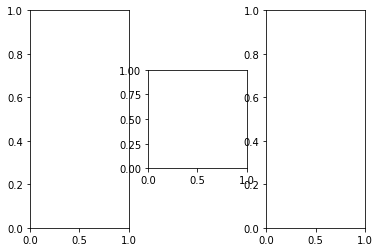

In [37]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)